In [ ]:
import cv2
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import xml.etree.ElementTree as ET
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans

In [ ]:
LABELS = ('sugarbeet', 'weed')
IMAGE_H, IMAGE_W = 512, 512
GRID_H,  GRID_W  = 16, 16
SIZE_CELL_W, SIZE_CELL_H = int(IMAGE_H/GRID_H), int(IMAGE_W/GRID_W)
NB_CLASS = len(LABELS)
batch_size = 16
lambda_coord = 5
lambda_noobj = 0.5

In [ ]:
train_image_folder = 'image/'
train_annot_folder = 'annotation/'
list_annotations = os.listdir(train_annot_folder)

### Classes 1 hot encoder

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(np.array(LABELS).reshape(2,1))

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='ignore', sparse=True)

### Load data

In [ ]:
names = []
data = []

In [ ]:
def extract_data(file_name):
  list_elements = []
  tree = ET.parse(file_name)    
  for item in tree.iter():
    if 'filename' in item.tag:
      file = item.text
    if 'object' in item.tag:
      dic = {}
      for attr in list(item):
        if "name" in attr.tag:
          dic["name"] = attr.text        
        if 'bndbox' in attr.tag:  
          for dim in list(attr):
            if "xmin" in dim.tag or "xmax" in dim.tag or "ymin" in dim.tag or "ymax" in dim.tag:
              dic[dim.tag] = dim.text        
      list_elements.append(dic)
  return file, list_elements

In [ ]:
def intersection_over_union(boxA, boxB):
  xA=np.maximum(boxA[0], boxB[0])
  yA=np.maximum(boxA[1], boxB[1])
  xB=np.minimum(boxA[2], boxB[2])
  yB=np.minimum(boxA[3], boxB[3])
  interArea=np.maximum(0, xB-xA)*np.maximum(0, yB-yA)
  boxAArea=(boxA[2]-boxA[0])*(boxA[3]-boxA[1])
  boxBArea=(boxB[2]-boxB[0])*(boxB[3]-boxB[1])
  return interArea/(boxAArea+boxBArea-interArea)

### Clustering to create anchor boxes

In [ ]:
dimensions = []
for file in list_annotations:
  _ , data = extract_data(train_annot_folder + file)
  for obj in data:  
    x_min = int(obj["xmin"]) / SIZE_CELL_W
    x_max = int(obj["xmax"]) / SIZE_CELL_W
    y_min = int(obj["ymin"]) / SIZE_CELL_H
    y_max = int(obj["ymax"]) / SIZE_CELL_H
    w = x_max - x_min
    h = y_max - y_min
    dimensions.append([w, h])

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(dimensions)
ANCHORS = kmeans.cluster_centers_
N_ANCHORS = len(ANCHORS)

### Visualizations

In [ ]:
def show_rect(xml_file):

  name, data = extract_data(train_annot_folder + xml_file) 
  img = cv2.imread('image/{}'.format(name))
  for obj in data:
    img = cv2.rectangle(img, (int(obj["xmin"]), int(obj["ymin"])), (int(obj["xmax"]), int(obj["ymax"])), (0, 255, 0), 2)
  return img

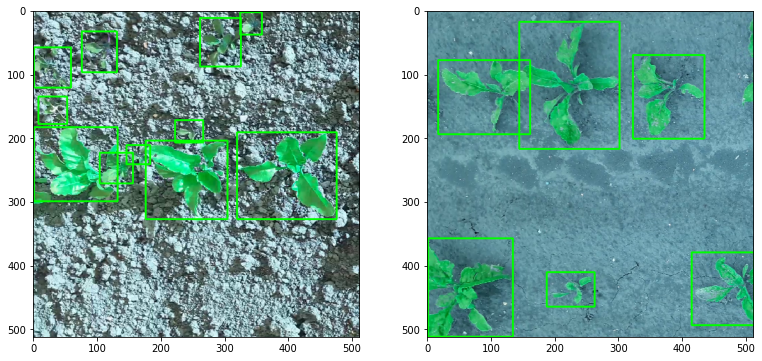

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.imshow(show_rect('X-250-0.xml'))
plt.subplot(1,3,2)
plt.imshow(show_rect('X3-40-0.xml'))

### Prepare labels

In [ ]:
labels = []
objects = []
images = []
max_objet = 40


for file in list_annotations:    
  
  name, data = extract_data(train_annot_folder + file)

  #get image
  image = Image.open(train_image_folder + name)
  images.append(np.array(image) / 255)

  #get associated labels
  label = np.zeros((GRID_H, GRID_W, N_ANCHORS, N_ANCHORS + NB_CLASS))
  objet = np.zeros((max_objet, 4 + NB_CLASS), dtype=np.float32)

  nb_obj = 0

  for obj in data:
     
    classe = enc.transform(np.array([obj["name"]]).reshape(-1,1)).toarray()[0]
    id_class = np.argmax(classe)
    x_min = int(obj["xmin"]) / SIZE_CELL_W
    x_max = int(obj["xmax"]) / SIZE_CELL_W
    y_min = int(obj["ymin"]) / SIZE_CELL_H
    y_max = int(obj["ymax"]) / SIZE_CELL_H

    objet[nb_obj]=[x_min, y_min, x_max, y_max, x_max - x_min, y_max - y_min]

    x_centre = int(x_min + (x_max - x_min) / 2)
    y_centre = int(y_min + (y_max - y_min) /2)
    x_cell = int(x_centre)
    y_cell = int(y_centre)

    a_x_min = x_centre - ANCHORS[:, 0] / 2
    a_x_max = x_centre + ANCHORS[:, 0] / 2      
    a_y_min = y_centre - ANCHORS[:, 1] / 2
    a_y_max = y_centre + ANCHORS[:, 1] / 2

    id_a = 0
    best_iou = 0

    for i in range(N_ANCHORS):
      iou = intersection_over_union([x_min, y_min, x_max, y_max], [a_x_min[i], a_y_min[i], a_x_max[i], a_y_max[i]])
      if iou > best_iou:
        best_iou = iou
        id_a = i
    label[y_cell, x_cell, id_a] = [(x_max + x_min) / 2, (y_max + y_min) / 2, x_max - x_min, y_max - y_min,1] + list(classe)
    nb_obj = nb_obj + 1
    
  objects.append(objet)  
  labels.append(label)

In [ ]:
labels = np.array(labels)
images = np.array(images)
objects = np.array(objects)

### Model



In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate, Dropout, MaxPooling2D, Reshape, Conv2D, Input, BatchNormalization, LeakyReLU, add

In [ ]:
# Custom Keras layer

class SpaceToDepth(keras.layers.Layer):

    def __init__(self, block_size, **kwargs):
        self.block_size = block_size
        super(SpaceToDepth, self).__init__(**kwargs)

    def call(self, inputs):
        x = inputs
        batch, height, width, depth = K.int_shape(x)
        batch = -1
        reduced_height = height // self.block_size
        reduced_width = width // self.block_size
        y = K.reshape(x, (batch, reduced_height, self.block_size,
                             reduced_width, self.block_size, depth))
        z = K.permute_dimensions(y, (0, 1, 3, 2, 4, 5))
        t = K.reshape(z, (batch, reduced_height, reduced_width, depth * self.block_size **2))
        return t

    def compute_output_shape(self, input_shape):
        shape =  (input_shape[0], input_shape[1] // self.block_size, input_shape[2] // self.block_size,
                  input_shape[3] * self.block_size **2)
        return tf.TensorShape(shape)

In [ ]:
import keras.backend as K

In [ ]:
# Yolo model, credit : https://github.com/experiencor/keras-yolo2)

input_image = tf.keras.layers.Input((IMAGE_H, IMAGE_W, 3), dtype='float32')

# Layer 1
x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
x = BatchNormalization(name='norm_1')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 2
x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
x = BatchNormalization(name='norm_2')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 3
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
x = BatchNormalization(name='norm_3')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 4
x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
x = BatchNormalization(name='norm_4')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 5
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
x = BatchNormalization(name='norm_5')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 6
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
x = BatchNormalization(name='norm_6')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 7
x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
x = BatchNormalization(name='norm_7')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 8
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
x = BatchNormalization(name='norm_8')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 9
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
x = BatchNormalization(name='norm_9')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 10
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
x = BatchNormalization(name='norm_10')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 11
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
x = BatchNormalization(name='norm_11')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 12
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
x = BatchNormalization(name='norm_12')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 13
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
x = BatchNormalization(name='norm_13')(x)
x = LeakyReLU(alpha=0.1)(x)

skip_connection = x

x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 14
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
x = BatchNormalization(name='norm_14')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 15
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
x = BatchNormalization(name='norm_15')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 16
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
x = BatchNormalization(name='norm_16')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 17
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
x = BatchNormalization(name='norm_17')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 18
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
x = BatchNormalization(name='norm_18')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 19
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
x = BatchNormalization(name='norm_19')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 20
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
x = BatchNormalization(name='norm_20')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 21
skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
skip_connection = BatchNormalization(name='norm_21')(skip_connection)
skip_connection = LeakyReLU(alpha=0.1)(skip_connection)

skip_connection = SpaceToDepth(block_size=2)(skip_connection)

x = concatenate([skip_connection, x])

# Layer 22
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
x = BatchNormalization(name='norm_22')(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.3)(x) # add dropout

# Layer 23
x = Conv2D(N_ANCHORS * (4 + 1 + NB_CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
output = Reshape((GRID_W, GRID_H, N_ANCHORS, 4 + 1 + NB_CLASS))(x)

model = keras.models.Model(input_image, output)

In [ ]:
class WeightReader:
    def __init__(self, weight_file):
        self.offset = 4
        self.all_weights = np.fromfile(weight_file, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]
    
    def reset(self):
        self.offset = 4

In [ ]:
weight_reader = WeightReader('yolov2.weights')

In [ ]:
weight_reader.reset()
nb_conv = 22

for i in range(1, nb_conv+1):
    conv_layer = model.get_layer('conv_' + str(i))
    conv_layer.trainable = True
    
    if i < nb_conv:
        norm_layer = model.get_layer('norm_' + str(i))
        norm_layer.trainable = True
        
        size = np.prod(norm_layer.get_weights()[0].shape)

        beta  = weight_reader.read_bytes(size)
        gamma = weight_reader.read_bytes(size)
        mean  = weight_reader.read_bytes(size)
        var   = weight_reader.read_bytes(size)

        weights = norm_layer.set_weights([gamma, beta, mean, var])       
        
    if len(conv_layer.get_weights()) > 1:
        bias   = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel, bias])
    else:
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel])


In [ ]:
layer   = model.layers[-2] # last convolutional layer
layer.trainable = True


weights = layer.get_weights()

new_kernel = np.random.normal(size=weights[0].shape)/(GRID_H*GRID_W)
new_bias   = np.random.normal(size=weights[1].shape)/(GRID_H*GRID_W)

layer.set_weights([new_kernel, new_bias])

### Train

In [ ]:
train_ds=tf.data.Dataset.from_tensor_slices((images, labels, objects)).batch(batch_size)

In [ ]:
def loss_fx(actual, preds, boxes):

  actual = tf.cast(actual, tf.float32)
  preds = tf.cast(preds, tf.float32)

  coordinates = tf.convert_to_tensor(tf.meshgrid(tf.range(GRID_W), tf.range(GRID_H)))
  coordinates = tf.transpose(coordinates, (2,1,0))
  coordinates = tf.transpose(coordinates, (1,0,2))
  coordinates = tf.cast(coordinates[None, ... , None,:], tf.float32)

# Localization loss
  preds_xy = tf.math.sigmoid(preds[..., 0:2]) + coordinates
  preds_wh = preds[..., 2:4]

  true_conf = actual[..., 4]
  true_xy = actual[..., 0:2]

  true_wh = tf.math.log(actual[..., 2:4] / ANCHORS)
  true_wh = tf.where(tf.math.is_inf(true_wh), tf.zeros_like(true_wh), true_wh)

  diff_xy = true_conf[..., None] * tf.square(preds_xy - true_xy)
  loss_xy = tf.reduce_sum(diff_xy)

  diff_wh = true_conf[..., None] * tf.square(preds_wh - true_wh)
  loss_wh = tf.reduce_sum(diff_wh)

# Classification loss
  preds_class = tf.math.sigmoid(preds[..., 5:])
  true_class = actual[..., 5:]
  class_loss = tf.reduce_sum(tf.math.square(preds_class - true_class), axis=4)
  class_loss = tf.reduce_sum(true_conf*class_loss)


# Confidence losses
  # Objectness
  pred_conf = tf.math.sigmoid(preds[..., 4])
  conf_objectness_diff = true_conf * tf.math.square(pred_conf - true_conf)
  conf_objectness_loss = tf.reduce_sum(conf_objectness_diff)
 
  # Non objectness
  pred_min_xy = preds_xy - (preds_wh / 2)
  pred_max_xy = preds_xy + (preds_wh / 2)

  pred_areas = preds_wh[..., 0] * preds_wh[..., 1]

  boxes_min_xy = boxes[..., 0:2]
  boxes_max_xy = boxes[..., 2:4]
  area_boxes = boxes[..., 4] * boxes[..., 5]

  true_conf_no_obj = []
  for i in range(len(actual)):        
    min_intersect_xy = tf.maximum(pred_min_xy[i][..., None, :], boxes_min_xy[i])
    max_intersect_xy = tf.minimum(pred_max_xy[i][..., None, :], boxes_max_xy[i])
    intersect_wh = tf.maximum(max_intersect_xy - min_intersect_xy, 0)

    intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]
    union_areas = pred_areas[i][..., None] + area_boxes[i] - intersect_area
    iou = intersect_area / union_areas
    best_iou = tf.reduce_max(iou, axis=-1)
    conf_no_obj = tf.cast(best_iou < 0.6, tf.float32) * (1-true_conf[i])
    true_conf_no_obj.append(conf_no_obj)

  true_conf_no_obj = tf.convert_to_tensor(true_conf_no_obj)

  conf_non_objectness_diff = true_conf_no_obj * tf.math.square(pred_conf - true_conf)
  conf_non_objectness_loss = tf.reduce_sum(conf_non_objectness_diff)

  total_loss = lambda_coord * loss_xy + lambda_coord * loss_wh \
        + class_loss + conf_objectness_loss + lambda_noobj * conf_non_objectness_loss

  return total_loss

### Training

In [ ]:
def train_step(images, labels, objs):
  with tf.GradientTape() as tape:
    predictions = model(images)
    loss = loss_fx(labels, predictions, objs)
        
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

In [ ]:
def train(train_ds, epochs):
    for epoch in range(epochs):
        for images, labels, objs in train_ds:
            loss = train_step(images, labels, objs)
        print("Epoch {}, error :".format(epoch+1), loss.numpy())    

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1E-4)
checkpoint = tf.train.Checkpoint(model = model)
checkpoint.restore(tf.train.latest_checkpoint("./training/"))

In [ ]:
train(train_ds, 400)
checkpoint.save(file_prefix="./training/")

Epoch 1, error : 214.8884
Epoch 2, error : 147.0822
Epoch 3, error : 109.856804
Epoch 4, error : 77.75916
Epoch 5, error : 62.031296
Epoch 6, error : 57.432213
Epoch 7, error : 50.72155
Epoch 8, error : 45.304375
Epoch 9, error : 42.829746
Epoch 10, error : 39.87617
Epoch 11, error : 38.767918
Epoch 12, error : 36.47096
Epoch 13, error : 35.275322
Epoch 14, error : 38.179688
Epoch 15, error : 35.345654
Epoch 16, error : 33.433117
Epoch 17, error : 30.359842
Epoch 18, error : 29.707748
Epoch 19, error : 26.84104
Epoch 20, error : 24.328804
Epoch 21, error : 23.467716
Epoch 22, error : 22.984932
Epoch 23, error : 22.295816
Epoch 24, error : 21.672104
Epoch 25, error : 26.711985
Epoch 26, error : 23.229843
Epoch 27, error : 26.842062
Epoch 28, error : 22.686882
Epoch 29, error : 20.89862
Epoch 30, error : 20.797895
Epoch 31, error : 18.176846
Epoch 32, error : 18.30077
Epoch 33, error : 15.9373045
Epoch 34, error : 15.770289
Epoch 35, error : 14.82771
Epoch 36, error : 14.856749
Epoch 37,

'./training/-1'

### Inférence

In [ ]:
checkpoint = tf.train.Checkpoint(model = model)
checkpoint.restore(tf.train.latest_checkpoint("./training/"))

In [ ]:
coordinates = tf.convert_to_tensor(tf.meshgrid(tf.range(GRID_W), tf.range(GRID_H)))
coordinates = tf.transpose(coordinates, (2,1,0))
coordinates = tf.transpose(coordinates, (1,0,2))
coordinates = tf.cast(coordinates[... , None,:], tf.float32)

In [ ]:
def plot_pred(img):
  
  prediction = model(img)

  preds_xy = prediction[0, ..., 0:4]
  pred_conf = tf.math.sigmoid(prediction[0, ..., 4])
  pred_classes = tf.nn.softmax(prediction[0, ..., 5:])
  classes = np.argmax(pred_classes, axis=-1)

  x_center = (coordinates[..., 0] + tf.math.sigmoid(preds_xy[..., 0])) * SIZE_CELL_W
  y_center = (coordinates[..., 1] + tf.math.sigmoid(preds_xy[..., 1])) * SIZE_CELL_H

  w = (tf.exp(preds_xy[..., 2]) * ANCHORS[:, 0]) * SIZE_CELL_W
  h = (tf.exp(preds_xy[..., 3]) * ANCHORS[:, 1]) * SIZE_CELL_H

  x_min = tf.cast(x_center-w/2, tf.int32)
  y_min = tf.cast(y_center-h/2, tf.int32)
  x_max = tf.cast(x_center+w/2, tf.int32)
  y_max = tf.cast(y_center+h/2, tf.int32)
  
  boxes = [] 

  for y in range(16):
    for x in range(16):
      for b in range(N_ANCHORS):
        if pred_conf[y, x, b]>0.1:
          boxes.append([x_min[y, x, b].numpy(), y_min[y, x, b].numpy(), x_max[y, x, b].numpy(), y_max[y, x, b].numpy()]) 
  
  return boxes         

In [ ]:
boxes = plot_pred(images[27][None, ...])
len(boxes)

(16, 16, 5)


13

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


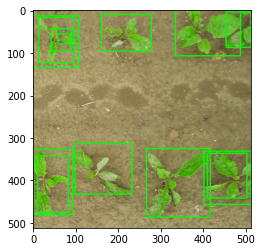

In [ ]:
test = images[27] 
for box in boxes:
   test = cv2.rectangle(test, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
plt.imshow(test)